## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn as skl
import sklearn.metrics 
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split

from random import sample 

from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import ResNet50 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
66487,00016433_000.png,No Finding,0,16433,32,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016433_000.png
26542,00006960_013.png,Effusion|Infiltration|Mass|Pleural_Thickening,13,6960,18,M,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00006960_013.png
76470,00018776_000.png,No Finding,0,18776,41,F,PA,2450,2669,0.143,0.143,NaN,/data/images_009/images/00018776_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
findings=set()
for x in all_xray_df['Finding Labels']:
    for y in x.split('|'):
        if y not in findings and y!= 'No Finding':
            findings.add(y)
findings

for f in findings:
    all_xray_df[f] = all_xray_df['Finding Labels'].map(lambda x:1 if f in x else 0)

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x:'pos' if x else 'neg')

## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, valid_data = train_test_split(df, test_size = 0.1, stratify = df['pneumonia_class'])
    
    p_inds = train_data[train_data.pneumonia_class=='pos'].index.tolist()
    np_inds = train_data[train_data.pneumonia_class=='neg'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    
    #take a balanced sample
    train_data = train_data.loc[p_inds + np_sample]
    
    return train_data, valid_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
def my_image_augmentation(h_flip=False ,rot= 0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = h_flip, 
                              vertical_flip = False, 
                              height_shift_range = 0.4, 
                              width_shift_range = 9.6, 
                              rotation_range = rot, 
                              shear_range = 0.5 ,
                              zoom_range= 0.5
                        )
    
    return my_idg


def make_train_gen(train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(h_flip=True, rot=9)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224, 224) , 
                                          batch_size = 45
                                          )
    

    return train_gen


def make_val_gen(val_data):
    
    my_val_idg = my_image_augmentation()

    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224, 224), 
                                              batch_size = 500) 
    
    
    return val_gen

In [7]:
train_data, val_data = create_splits(all_xray_df)
train_gen=make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2576 validated image filenames belonging to 2 classes.
Found 11212 validated image filenames belonging to 2 classes.


In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

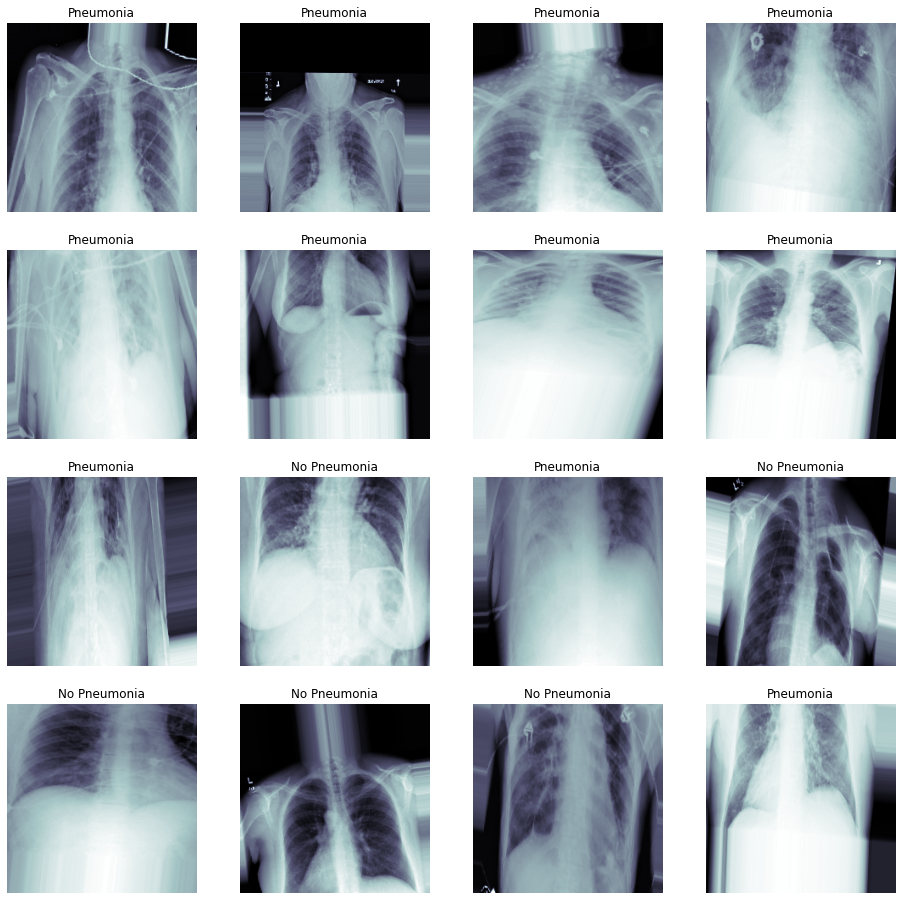

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model(lay_of_interest='block5_pool'):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

    
    return vgg_model


In [11]:
def build_my_model(pretrained):
    for layer in pretrained.layers[0:17]:
        layer.trainable = False
    
    new_model = Sequential()
    new_model.add(pretrained)
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    new_model.add(Flatten())
    new_model.add(Dropout(0.5))

    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))

    #new_model.add(Dense(512, activation='relu'))
    #new_model.add(Dropout(0.5))

    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

pretrained= load_pretrained_model()
my_model = build_my_model(pretrained)

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#my_model.load_weights(weight_path)
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                        validation_data = (valX, valY), 
                        epochs = 20, 
                        callbacks = callbacks_list)

Epoch 1/20
58/58 [==============================] - 79s 1s/step - loss: 0.7659 - binary_accuracy: 0.5148 - val_loss: 0.8114 - val_binary_accuracy: 0.3140

Epoch 00001: val_loss improved from inf to 0.81143, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
58/58 [==============================] - 67s 1s/step - loss: 0.7209 - binary_accuracy: 0.5237 - val_loss: 0.7552 - val_binary_accuracy: 0.3300

Epoch 00002: val_loss improved from 0.81143 to 0.75519, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
58/58 [==============================] - 70s 1s/step - loss: 0.7127 - binary_accuracy: 0.5353 - val_loss: 0.6600 - val_binary_accuracy: 0.6140

Epoch 00003: val_loss improved from 0.75519 to 0.65997, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
58/58 [==============================] - 69s 1s/step - loss: 0.6871 - binary_accuracy: 0.5543 - val_loss: 0.9319 - val_binary_accuracy: 0.0560

Epoch 00004: val_loss did not improve from 0.65997
Epoch 5/20
58/58 [=========

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


In [ ]:
t_y=valY
p_y=my_model.predict(valX)
## plot figures
plot_auc(t_y,p_y)
plot_precision_recall_curve(t_y, p_y)
plot_history(history)
# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)